# NBA Team Scoring Analysis



## Initialize

In [2]:
# Common imports
import numpy as np
import pandas as pd
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    plt.figure(facecolor='white')
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Fetch Data

### setup GDrive and Kaggle

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/kaggle/"
!kaggle config set -n path -v "/content/gdrive/My Drive/kaggle/"



- path is now set to: /content/gdrive/My Drive/kaggle/


In [5]:


from kaggle.api.kaggle_api_extended import KaggleApi

data_path = os.path.join("/content/gdrive/My Drive/kaggle","")
dataset = "nathanlauga/nba-games"
api = KaggleApi()
api.config_dir = data_path
api.authenticate()


### Save dataset to Google Drive

In [6]:
data_path = os.path.join("/content/gdrive/My Drive/kaggle","NBA","")
api.dataset_download_files(dataset=dataset, path=data_path, quiet=False, unzip=True)

100%|██████████| 18.1M/18.1M [00:00<00:00, 119MB/s]

In [7]:
# load data
game_details = pd.read_csv(data_path + "games_details.csv")
game_summary = pd.read_csv(data_path + "games.csv")

## Prepare data
### Inspect data

In [8]:
game_details.head(1)

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,START_POSITION,COMMENT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS
0,21900895,1610612749,MIL,Milwaukee,202083,Wesley Matthews,F,NaN,27:08,3.0,11.0,0.273,2.0,7.0,0.286,0.0,0.0,0.0,4.0,4.0,8.0,2.0,2.0,0.0,0.0,0.0,8.0,11.0


In [9]:
game_summary.head(1)

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2020-03-01,21900895,Final,1610612766,1610612749,2019,1610612766,85.0,0.354,0.9,0.229,22.0,47.0,1610612749,93.0,0.402,0.762,0.226,20.0,61.0,0


In [10]:
game_details.columns

Index(['GAME_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_CITY', 'PLAYER_ID',
       'PLAYER_NAME', 'START_POSITION', 'COMMENT', 'MIN', 'FGM', 'FGA',
       'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB',
       'DREB', 'REB', 'AST', 'STL', 'BLK', 'TO', 'PF', 'PTS', 'PLUS_MINUS'],
      dtype='object')

In [11]:
game_summary.columns

Index(['GAME_DATE_EST', 'GAME_ID', 'GAME_STATUS_TEXT', 'HOME_TEAM_ID',
       'VISITOR_TEAM_ID', 'SEASON', 'TEAM_ID_home', 'PTS_home', 'FG_PCT_home',
       'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home', 'TEAM_ID_away',
       'PTS_away', 'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away',
       'REB_away', 'HOME_TEAM_WINS'],
      dtype='object')

### Drop extra columns

In [12]:
gd = game_details.drop(columns=['TEAM_ABBREVIATION', 'TEAM_CITY', 
    'PLAYER_NAME', 'START_POSITION', 'COMMENT', 'MIN', 'FGM', 'FGA',
    'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB',
    'DREB', 'REB', 'AST', 'STL', 'BLK', 'TO', 'PF', 'PLUS_MINUS'])

In [13]:
gs = game_summary.drop(columns=['GAME_STATUS_TEXT', 'TEAM_ID_home', 'PTS_home', 'FG_PCT_home',
       'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home', 'TEAM_ID_away', 'SEASON',
       'PTS_away', 'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away','GAME_DATE_EST',
       'REB_away'])

### Prepare Game details dataset

In [14]:
def point_range(x, min_range=10, max_range=np.infty):
    t = np.select(condlist=[x>=max_range, x>=min_range], choicelist=[0,x], default=0)
    #print(min_range,max_range,t.sum(), t)
    return t.sum()
    
#Fill PTS columns with zero if it has no value
gd.fillna({'PTS':0}, inplace=True)
gd_aggr = gd.groupby(by=["GAME_ID","TEAM_ID"], as_index=True).agg(
    PTS_10=('PTS', lambda x: point_range(x,10,20)), 
    PTS_20=('PTS',  lambda x: point_range(x,20,30)),
    PTS_30=('PTS',  lambda x: point_range(x,30,40)),
    PTS_40=('PTS',  lambda x: point_range(x,40,50)),
    PTS_50=('PTS',  lambda x: point_range(x,50)),
    TOTAL=('PTS',np.sum), PTS_HI=('PTS',np.max)
    ).astype('int64')

In [15]:
gd_aggr.head(100)

PTS_10  PTS_20  PTS_30  PTS_40  PTS_50  TOTAL  PTS_HI
GAME_ID  TEAM_ID                                                          
10300001 1610612742      52       0       0       0       0     85      16
         1610612762      20       0       0       0       0     90      10
10300002 1610612749      49      21       0       0       0     94      21
         1610612763      21      42       0       0       0    105      21
10300003 1610612739      67       0       0       0       0    100      19
...                     ...     ...     ...     ...     ...    ...     ...
10400100 1610612753      75      22       0       0       0    109      22
10400101 1610612741      29      22       0       0       0     71      22
         1610612754      62       0       0       0       0     91      18
10400102 1610612749      50       0       0       0       0     76      18
         1610612750      24      22       0       0       0     75      22

[100 rows x 7 columns]

### Prepare game summary dataset

In [16]:
gs_melt = gs.melt(id_vars=['GAME_ID', 'HOME_TEAM_WINS'],value_name='TEAM_ID', var_name='HOME')

gs_melt['HOME'].replace(to_replace='HOME_TEAM_ID', value=1, inplace=True)
gs_melt['HOME'].replace(to_replace='VISITOR_TEAM_ID', value=0, inplace=True)

def conditions(s):
    if ((s['HOME_TEAM_WINS'] == 1) and (s['HOME'] == 1)) or ((s['HOME_TEAM_WINS'] == 0) and (s['HOME'] == 0)) :
        return 1
    else:
        return 0

gs_melt['WON'] = gs_melt.apply(conditions, axis=1)
gs_melt.drop('HOME_TEAM_WINS',axis=1, inplace=True)

In [17]:
gs_melt.head()

,GAME_ID,HOME,TEAM_ID,WON
0,21900895,1,1610612766,0
1,21900896,1,1610612750,0
2,21900897,1,1610612746,1
3,21900898,1,1610612743,1
4,21900899,1,1610612758,1


### Merge 2 datasets

In [18]:
game_data = pd.merge(gd_aggr, gs_melt, how='inner', left_on=['GAME_ID','TEAM_ID'], right_on = ['GAME_ID','TEAM_ID'])

In [19]:
game_data.head()

,GAME_ID,TEAM_ID,PTS_10,PTS_20,PTS_30,PTS_40,PTS_50,TOTAL,PTS_HI,HOME,WON
0,10300001,1610612742,52,0,0,0,0,85,16,0,0
1,10300001,1610612762,20,0,0,0,0,90,10,1,1
2,10300002,1610612749,49,21,0,0,0,94,21,0,0
3,10300002,1610612763,21,42,0,0,0,105,21,1,1
4,10300003,1610612739,67,0,0,0,0,100,19,0,1


### Save prepared dataset

In [22]:
gd_final = game_data[['PTS_10','PTS_20','PTS_30','PTS_40','PTS_50','PTS_HI','TOTAL','WON']]
gd_final.to_csv(data_path + "game_scoring.csv")

In [8]:
gd_final = pd.read_csv(data_path + "game_scoring.csv")
gd_final

,Unnamed: 0,PTS_10,PTS_20,PTS_30,PTS_40,PTS_50,PTS_HI,TOTAL,WON
0,0,52,0,0,0,0,16,85,0
1,1,20,0,0,0,0,10,90,1
2,2,49,21,0,0,0,21,94,0
3,3,21,42,0,0,0,21,105,1
4,4,67,0,0,0,0,19,100,1
...,...,...,...,...,...,...,...,...,...
46187,46187,29,20,36,0,0,36,105,1
46188,46188,35,26,31,0,0,31,106,1
46189,46189,73,26,0,0,0,26,105,0
46190,46190,23,43,30,0,0,30,110,0


## Data Analysis

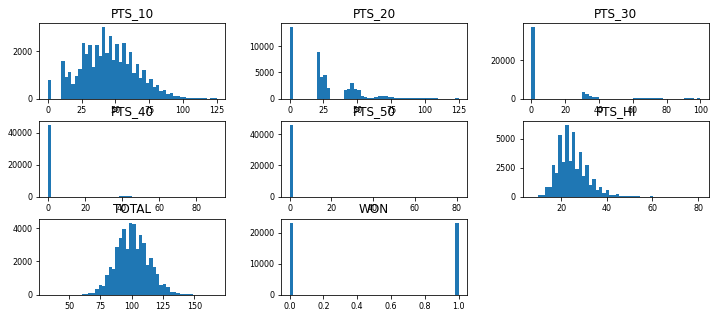

In [23]:
gd_final.hist(figsize=(12,5),bins=50,  linewidth=1.0,
           xlabelsize=8, ylabelsize=8, grid=False ) 

plt.show()

In [24]:
gd_final.head()

,PTS_10,PTS_20,PTS_30,PTS_40,PTS_50,PTS_HI,TOTAL,WON
0,52,0,0,0,0,16,85,0
1,20,0,0,0,0,10,90,1
2,49,21,0,0,0,21,94,0
3,21,42,0,0,0,21,105,1
4,67,0,0,0,0,19,100,1


In [25]:
corr_matrix = gd_final.corr()
corr_matrix["WON"].sort_values(ascending=False)

WON       1.000000
TOTAL     0.423352
PTS_HI    0.198338
PTS_20    0.167306
PTS_30    0.108493
PTS_10    0.067973
PTS_40    0.052274
PTS_50    0.022739
Name: WON, dtype: float64

## Visualization

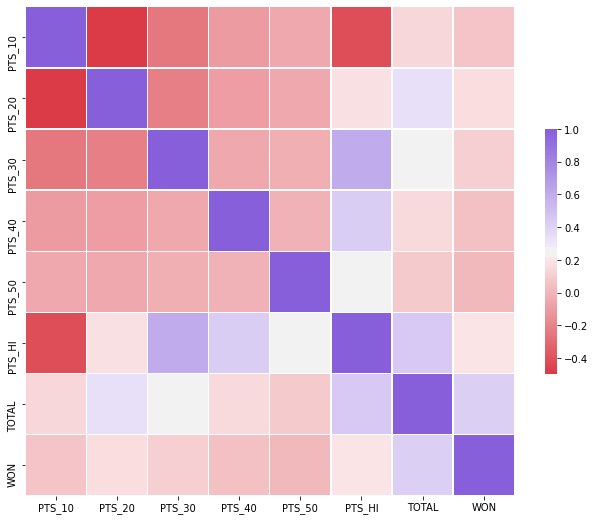

In [27]:
# plot correlation matrix
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(10, 275, as_cmap=True)

sns.heatmap(corr_matrix, cmap=cmap, square=True,
            linewidths=0.5, cbar_kws={"shrink": 0.5}, ax=ax)

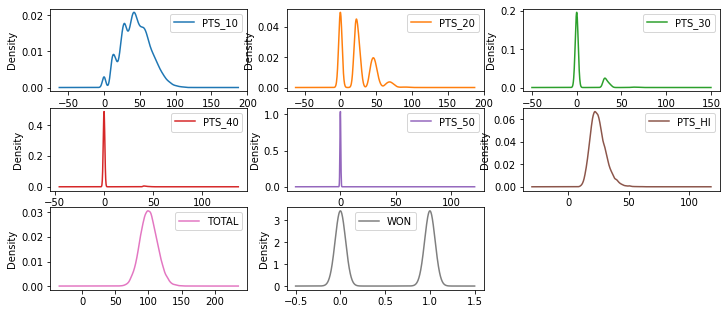

In [28]:
gd_final.plot(kind='density', subplots=True, layout=(4,3), sharex=False, figsize=(12,7))
plt.show()

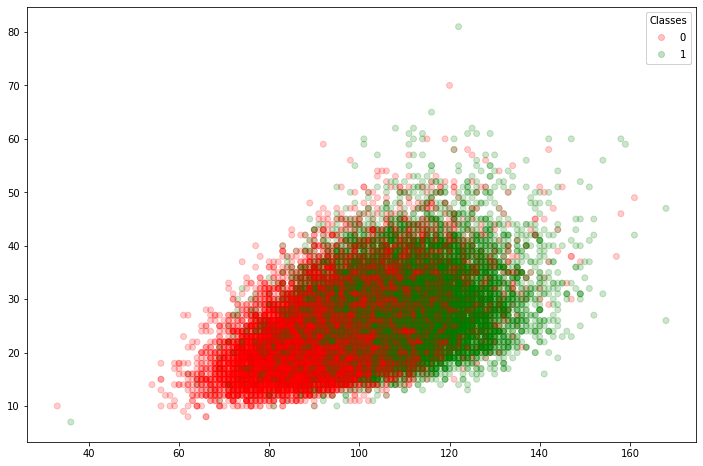

In [29]:
fig, ax = plt.subplots(figsize=(12,8))

scatter = ax.scatter(x=gd_final['TOTAL'], y=gd_final['PTS_HI'], c=gd_final['WON'],cmap=mpl.colors.ListedColormap(['red','green']),alpha=0.2)

# produce a legend with the unique colors from the scatter
legend = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend)
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


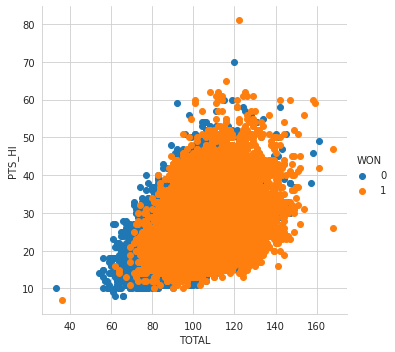

In [30]:
sns.set_style("whitegrid")
sns.FacetGrid(gd_final, hue="WON", size=5) \
   .map(plt.scatter, "TOTAL", "PTS_HI") \
   .add_legend()
plt.show()

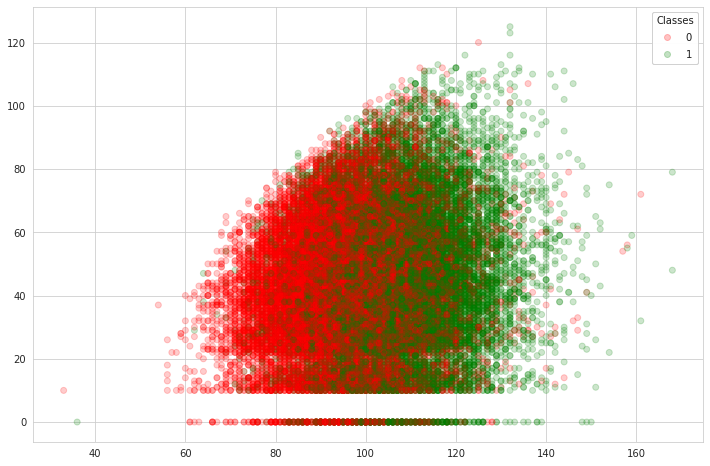

In [31]:
fig, ax = plt.subplots(figsize=(12,8))

scatter = ax.scatter(x=gd_final['TOTAL'], y=gd_final['PTS_10'], c=gd_final['WON'],cmap=mpl.colors.ListedColormap(['red','green']),alpha=0.2)

# produce a legend with the unique colors from the scatter
legend = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend)


plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


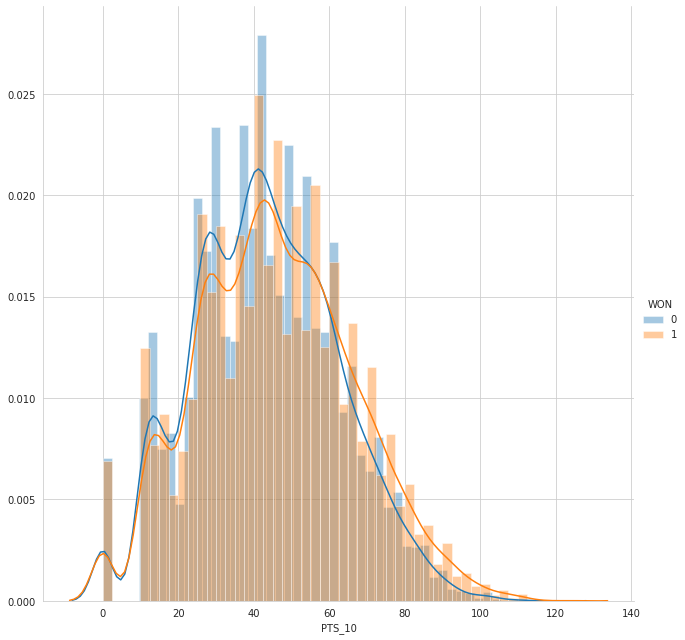

In [32]:
sns.FacetGrid(gd_final,hue='WON',size=9).map(sns.distplot,'PTS_10').add_legend()

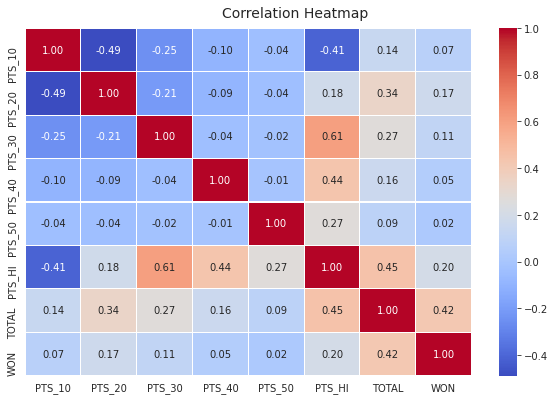

In [33]:
# Correlation Matrix Heatmap
f, ax = plt.subplots(figsize=(10, 6))

hm = sns.heatmap(round(corr_matrix,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Correlation Heatmap', fontsize=14)

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


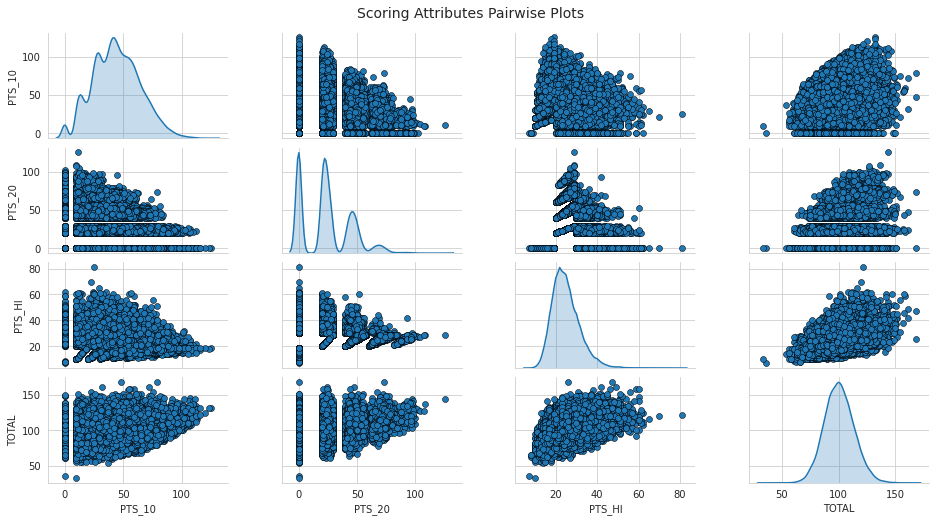

In [34]:
# Pair-wise Scatter Plots
cols = ['PTS_10', 'PTS_20', 'PTS_HI', 'TOTAL']
pp = sns.pairplot(gd_final[cols], size=1.8, aspect=1.8,
                  plot_kws=dict(edgecolor="k", linewidth=0.5),
                  diag_kind="kde", diag_kws=dict(shade=True))

fig = pp.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Scoring Attributes Pairwise Plots', fontsize=14)

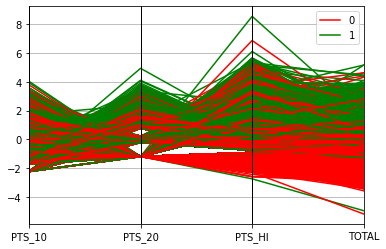

In [9]:
# Scaling attribute values to avoid few outiers
cols = ['PTS_10', 'PTS_20', 'PTS_HI', 'TOTAL']
subset_df = gd_final[cols]

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

scaled_df = ss.fit_transform(subset_df)
scaled_df = pd.DataFrame(scaled_df, columns=cols)
final_df = pd.concat([scaled_df, gd_final['WON']], axis=1)
final_df.head()

# plot parallel coordinates
from pandas.plotting import parallel_coordinates
pc = parallel_coordinates(final_df, 'WON', color=('red', 'green'))

In [36]:

# Visualizing 4-D mix data using scatter plots
# leveraging the concepts of hue and depth
"""
  fig = plt.figure(figsize=(8, 6))
  t = fig.suptitle('PTS_10, PTS_20, PTS_HI, WON', fontsize=14)
  ax = fig.add_subplot(111, projection='3d')

  xs = list(gd_final['PTS_10'])
  ys = list(gd_final['PTS_20'])
  zs = list(gd_final['PTS_HI'])
  data_points = [(x, y, z) for x, y, z in zip(xs, ys, zs)]
  colors = ['red' if wt == 0 else 'green' for wt in list(gd_final['WON'])]

  for data, color in zip(data_points, colors):
      x, y, z = data
      ax.scatter(x, y, z, alpha=0.4, c=color, edgecolors='none', s=30)

  ax.set_xlabel('PTS_10')
  ax.set_ylabel('PTS_20')
  ax.set_zlabel('PTS_HI')
"""

"\n  fig = plt.figure(figsize=(8, 6))\n  t = fig.suptitle('PTS_10, PTS_20, PTS_HI, WON', fontsize=14)\n  ax = fig.add_subplot(111, projection='3d')\n\n  xs = list(gd_final['PTS_10'])\n  ys = list(gd_final['PTS_20'])\n  zs = list(gd_final['PTS_HI'])\n  data_points = [(x, y, z) for x, y, z in zip(xs, ys, zs)]\n  colors = ['red' if wt == 0 else 'green' for wt in list(gd_final['WON'])]\n\n  for data, color in zip(data_points, colors):\n      x, y, z = data\n      ax.scatter(x, y, z, alpha=0.4, c=color, edgecolors='none', s=30)\n\n  ax.set_xlabel('PTS_10')\n  ax.set_ylabel('PTS_20')\n  ax.set_zlabel('PTS_HI')\n"

## Initial Training

### Split Train and Test data

In [44]:
from sklearn.model_selection import train_test_split

X = gd_final[['PTS_10','PTS_20','PTS_30','PTS_40','PTS_50','PTS_HI','TOTAL']]
y = gd_final[gd_final.columns[-1]]

#split data into train + val set and test set
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42)

#split train into train set = 50k and val set = 10k
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1, random_state=42)

## Train various classifiers

In [47]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

C = 5
alpha = 1 / (C * len(X))

random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
mlp_clf = MLPClassifier(random_state=42)
log_clf = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)
lin_clf = LinearSVC(loss="hinge", C=C, random_state=42)
svm_clf = SVC(kernel="linear", C=C)
sgd_clf = SGDClassifier(loss="hinge", learning_rate="constant", eta0=0.001, alpha=alpha, max_iter=1000, tol=1e-3, random_state=42)


In [48]:
estimators = [random_forest_clf, extra_trees_clf, mlp_clf, log_clf, lin_clf, svm_clf, sgd_clf]
for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(X_train, y_train)

Training the RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
Training the ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training the SVC(C=5, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Training the SGDClassifier(alpha=4.329754069968826e-06, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.001, fit_intercept=True,
              l1_ratio=0.15, learning_rate='constant', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)


In [49]:
for estimator in estimators:
    print(estimator.__class__.__name__, estimator.score(X_val, y_val))

RandomForestClassifier 0.6270562770562771
ExtraTreesClassifier 0.6196969696969697
MLPClassifier 0.6725108225108225
LogisticRegression 0.6807359307359307
LinearSVC 0.5471861471861472
SVC 0.6798701298701298
SGDClassifier 0.5344155844155845


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)